<a href="https://colab.research.google.com/github/theofarouk/IMDA/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hazem Wannous, GenAI summer school, 2025

# Autoencoders

**Autoencoders** are a particular type of neural network that compresses the data into a **latent vector**, often denoted $z$ in literature, with the goal of preserving the opportunity to recreate the exact same image in the future. Because autoencoders learn representations instead of labels, autoencoders belong to representation learning, a subfield of machine learning, but not necessarily deep learning.

## Architecture
Autoencoders consist of two networks:

* Encoder
* Decoder

The goal of the **encoder** is to compress an image, video, or any piece of data that can be represented as a tensor, into a _latent vector_. The **decoder** does, as you might have guessed, the exact opposite.

To maximize performance, minimize the loss that is, encoders and decoders are typically symmetrical together. Naturally, the input size is equal to the output size of an autoencoder.

Autoencoders always have less input neurons in the middle layer than in the input and output layer. This is called the **bottleneck**. If it weren't for this bottleneck, the autoencoders could just copy this data over from the input to the output layer without compressing it.

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) [source](https://en.wikipedia.org/wiki/File:Autoencoder_structure.png)

## Training

Encoders and decoders _can_ be trained separately, but usually they are trained in one go. In order to do so, one stacks the coders together in one **stacked autoencoder**.

If one desires to train autoencoders separately, one starts by using the first hidden layer, discaring every other layer, except for the input and output layers of course. He uses the original training data at this point. Next, he uses the latent vector $z$ learnt by this mini-autoencoder and trains another autoencoder in the same way, treating the latent vectors as original data. Once the desired depth is reached, one can stack all output layers, which provided the latent vectors, together in a sinle encoder. This approach is not used in practise a lot, but literature might refer to it as greedy layerwise training so it's good to know what it means.

## Appliciations

While the phase "finding patterns" might not seem very interesting, there are a lot of exciting applications of autoencoders. We will look at three of those today:

1. Dense autoencoder: compressing data.
2. Denoising autoencoder: removing noise from poor training data.
3. Convolutional autoencoder: a building block of DCGANs, self-supervised learning.

While all of these applications use pattern finding, they have different use cases making autoencoders one of the most exciting topics of machine learning.

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from tensorflow import keras

## Loading the data

We will load MNIST, but without labels because representation learning is **unsupervised**, or **self-supervised** which is the prefered term. (https://twitter.com/ylecun/status/1123235709802905600)

In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## A simple autoencoder

Let's start by looking at the simplest possible autoencoder.

The `encoder` is a sequential neural network with $28 \times 28$ input neurons, $100$ neurons in the second layer and $30$ in the third. The third layer is called the "bottleneck". Feel free to play around with this variable to see how it affects results.

In [5]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The decoder is the same, but in opposite order. Note that keras needs to know the input shape at this point. The input shape of the decoder is the shape of $z$, also called `zDim` as you will see later on.

In [6]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now stack them for training:

In [7]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

Note that we use binary cross entropy loss in stead of categorical cross entropy. The reason for that is because we are not classifying latent vectors to belong to a particular class, we do not even have classes!, but rather are trying to predict whether a pixel should be activated or not.

In [8]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                   optimizer='adam')

Notice how the $x$ and $y$, both $x$, `x_train` if you like, are equal:

In [9]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                                  validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1930 - val_loss: 0.1050
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1036 - val_loss: 0.0962
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0962 - val_loss: 0.0927
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0932 - val_loss: 0.0904
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0912 - val_loss: 0.0889
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0898 - val_loss: 0.0881
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0891 - val_loss: 0.0872
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0882 - val_loss: 0.0868
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0876 - val_loss: 0.0863
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0871 - val_loss: 0.0858


Let's look at how the autoencoder reconstructs images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


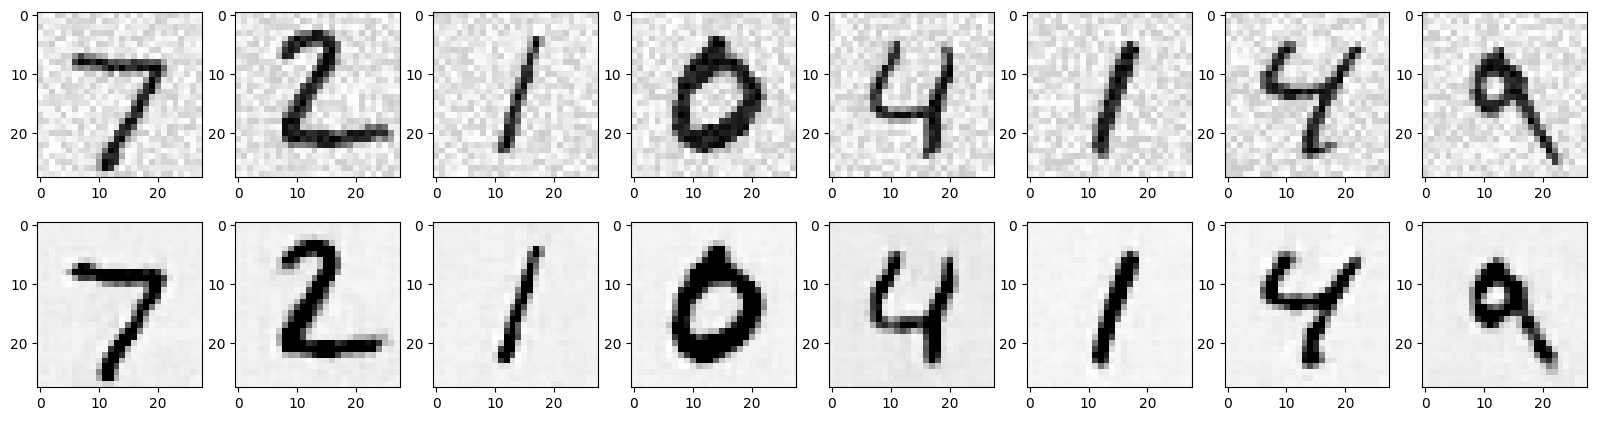

In [47]:
import matplotlib.pyplot as plt

figsize(20, 5)
for i in range(8):
  subplot(2, 8, i + 1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Just from this vector:

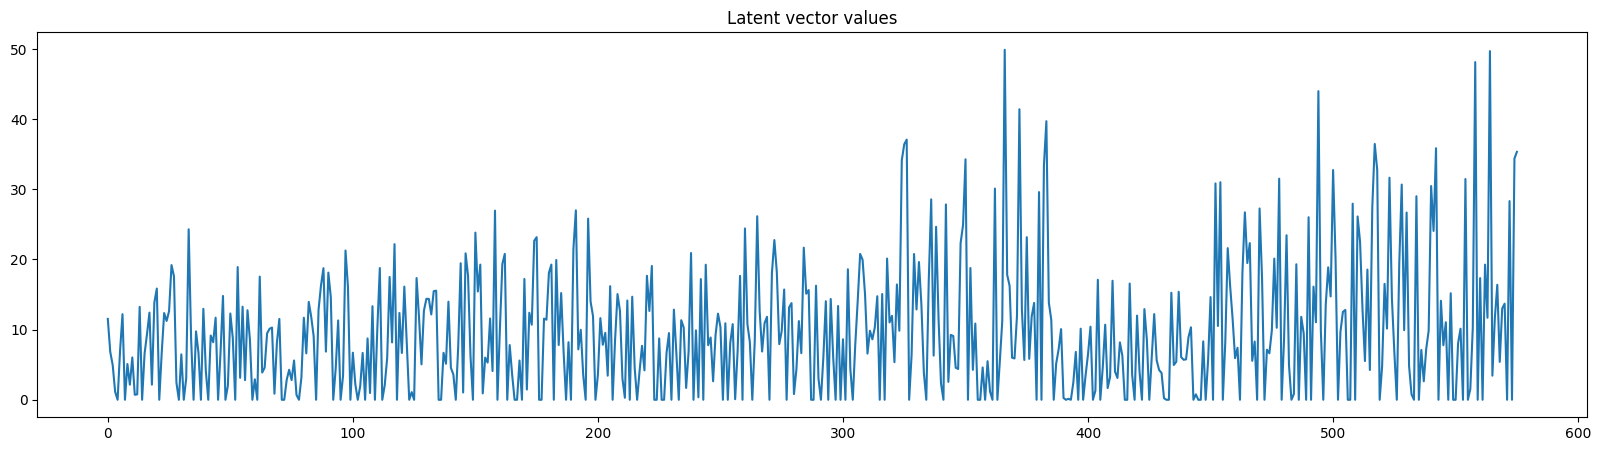

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


TypeError: Invalid shape (1, 3, 3, 64) for image data

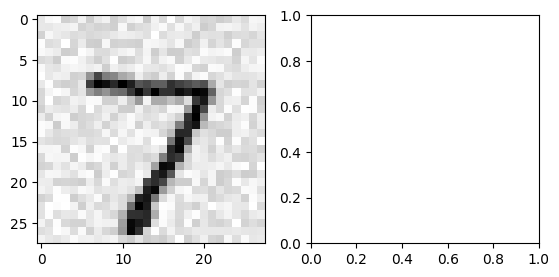

In [48]:
i = 0 # change this number

plt.plot(latent_vector.flatten())
plt.title("Latent vector values")
plt.show()


figsize(10, 5)

subplot(1, 3, 1)
imshow(x_test[i], cmap="binary")

subplot(1, 3, 2)
latent_vector = encoder.predict(x_test[i].reshape((1, 28, 28)))
imshow(latent_vector, cmap="binary")

subplot(1, 3, 3)
pred = decoder.predict(latent_vector)
imshow(x_test[i], cmap="binary")

In [12]:
30 / (28 * 28), 1 - 30 / (28 * 28)

(0.03826530612244898, 0.9617346938775511)

That's 96.2% compression! Pretty amazing, huh?

## Denoising autoencoder

The last application of autoencoders we look at today are denoising autoencoders. You probably have no difficulty classifying the images below as 7's.

In [13]:
import numpy as np

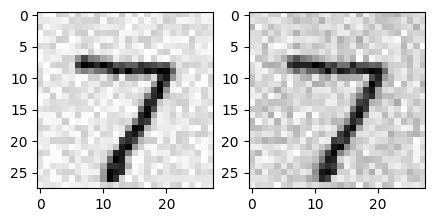

In [49]:
figsize(5, 10)
subplot(1, 2, 1)
imshow(x_test[0], cmap="binary")

subplot(1, 2, 2)
noise = np.random.random((28, 28)) / 4
imshow(x_test[0] + noise, cmap="binary")

But in machine learning, this noise can be catasrophic. Luckily machine learning also has a solution for this problem: auto encoders!

By applying noise to the images inputted to the encoder and setting the clean image as desired output, $y$, an autoencoder can learn to remove noise from the image.

Let's look at such an encoder:

In [15]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu")
])

In [16]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [17]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [18]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

Now create a dataset filled with noise:

In [19]:
x_train_noise = x_train + ((np.random.random(x_train.shape)) / 4)
x_test_noise = x_test + ((np.random.random(x_test.shape)) / 4)

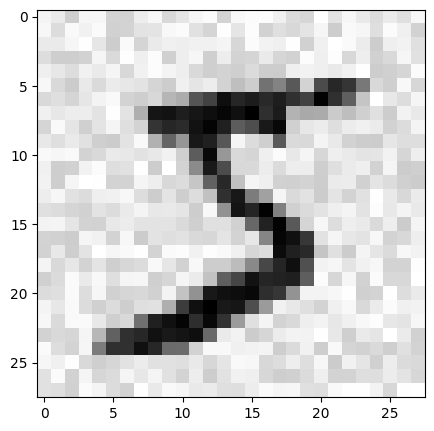

In [20]:
imshow(x_train_noise[0], cmap="binary")

And finally train the stacked autoencoder with noise input data and clean output data.

In [21]:
history = stacked_autoencoder.fit(x_train_noise, x_train, epochs=10,
                                  validation_data=[x_test_noise, x_test])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2088 - val_loss: 0.1218
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1196 - val_loss: 0.1104
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1088 - val_loss: 0.1018
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1028 - val_loss: 0.0989
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0995 - val_loss: 0.0963
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0969 - val_loss: 0.0949
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0949 - val_loss: 0.0924
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0934 - val_loss: 0.0923
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0924 - val_loss: 0.0912
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0914 - val_loss: 0.0900


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


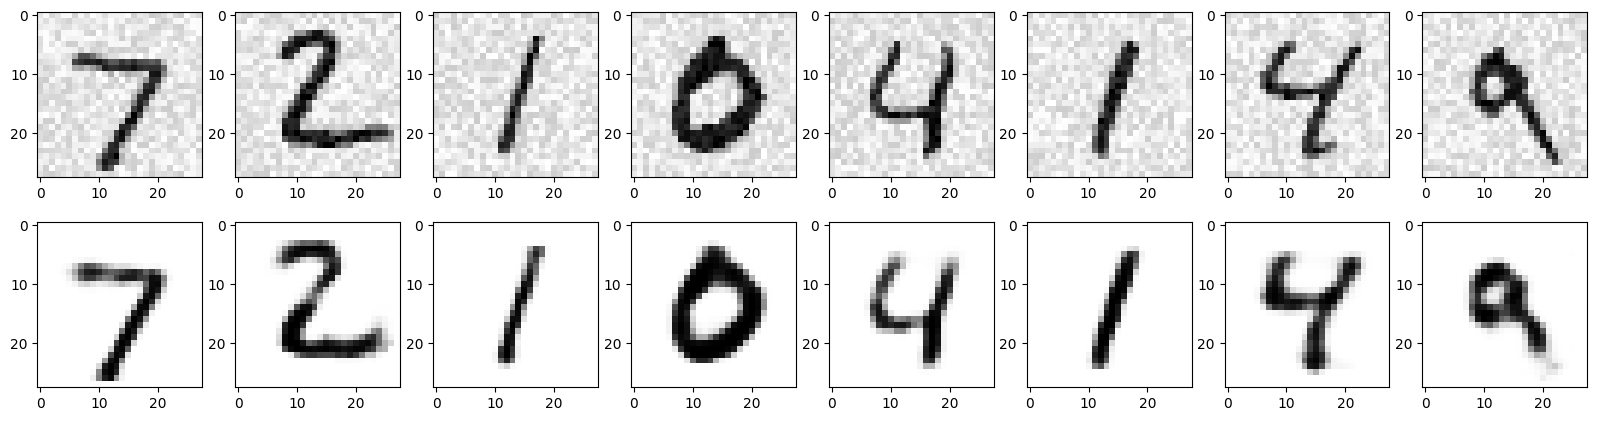

In [22]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  imshow(x_test_noise[i], cmap="binary")

  subplot(2, 8, i+8+1)
  pred = stacked_autoencoder.predict(x_test_noise[i].reshape((1, 28, 28)))
  imshow(pred.reshape((28, 28)), cmap="binary")

Mindblowing!

## Convolutional autoencoder

> Ajouter une citation



Apart from data compression, autoencoders can also be used for self-supervised image classification.

The first layers of the encoder learn to recognize patterns in the data very well in order to compress the data. If you don't have access to much labelled data, but a lot of unlabelled data, it's possible to train an autoencoder and copy the first layers from the autoencoder to the classifier network. This can be compared to transfer learning, where you only have to train the head afterwards.

It is well known that convolutional layers are perfect for finding patterns in data, so it's good to know they can also be used in autoencoders. To "de-convolve" images in the decoder, transposed convolutional layers are used. For more information on transposed convolutional layers, checkout [this blog post](https://rickwierenga.com/blog/s4tf/s4tf-gan.html) I have written which explains them in more detail. See the last section "Autoencoders and GANs" of this notebook for more information on the beautiful relation between GANs and autoencoders.

Let's look at a convolutional encoder:

In [23]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
x_train = x_train + ((np.random.random(x_train.shape)) / 4)
x_test = x_test + ((np.random.random(x_test.shape)) / 4)

The weights learnt by this encoder could be copied to the classifier.

In [25]:
encoder.predict(x_test[0].reshape((1, 28, 28))).shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 3, 3, 64)

Notice how $z \in \mathbb{R}^{1 \times 3 \times 3 \times 64}$. Now we build its counterpart, the decoder, with transposed convolutional layers to recreate a grayscale $28 \times 28$ image.

In [26]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [27]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [28]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

In [29]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                         validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.4236 - val_loss: 0.2986
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2978 - val_loss: 0.2708
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2735 - val_loss: 0.2549
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2610 - val_loss: 0.2495
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2552 - val_loss: 0.2455
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2520 - val_loss: 0.2431
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2492 - val_loss: 0.2414
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2468 - val_loss: 0.2410
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2452 - val_loss: 0.2362
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2431 - val_loss: 0.2352


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


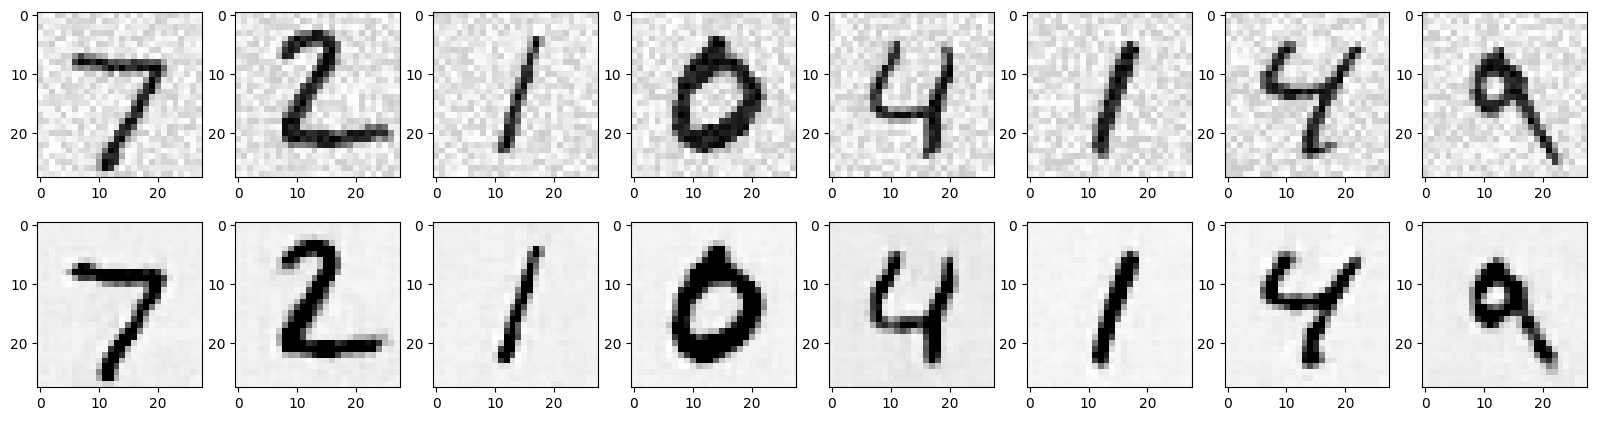

In [30]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")